In [1]:
from PIL import Image
import pandas as pd
import os
import torch
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random
import torch.nn.functional as F

In [2]:
class ArtDataset(Dataset):
    def __init__(self,  csv_file, img_dir, transform=None): 
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        self.data_info = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.data_info)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name = os.path.join(self.img_dir,
                                self.data_info.iloc[idx, 0])
        
        image = Image.open(img_name).convert('RGB')
        
        a = np.asarray(image)
        #print(a.shape, img_name)
        date = self.data_info.iloc[idx, 1]
        
        if self.transform:
            image = self.transform(image)
            
        sample = {'image': image, 'date': date}
        return sample

### Test on the dataset

0 <PIL.Image.Image image mode=RGB size=224x224 at 0x13997FF90>
1 <PIL.Image.Image image mode=RGB size=224x224 at 0x13938FD50>
2 <PIL.Image.Image image mode=RGB size=224x224 at 0x1397EBCD0>


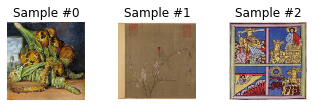

In [3]:
art_data_tensor = ArtDataset(csv_file = 'train_1_classes.csv', img_dir = 'train_1/', 
                     transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(),
                                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                          std=[0.229, 0.224, 0.225])]))


test_ds_pil = ArtDataset(csv_file = 'train_1_classes.csv', img_dir = 'train_1/', 
                     transform = transforms.Compose([transforms.Resize((224,224))]))
                                                    

#test_ds_pil = ArtDataset(csv_file = 'train_1_info.csv', img_dir = 'train_1/', 
                     #transform =None)
fig = plt.figure()

for i in range(3):
    sample = test_ds_pil[i]
    print(i, sample['image'])
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample['image'])
    
 

    

In [4]:
indicies = np.arange(len(art_data_tensor))
random.Random(148).shuffle(indicies)
split_index1 = int(len(art_data_tensor) * 0.68)
split_index2 = int(len(art_data_tensor) * 0.8)
subset_indices_train = indicies[:split_index1]
subset_indices_valid = indicies[split_index1:split_index2]
subset_indices_test = indicies[-split_index2:]
train_loader = torch.utils.data.DataLoader(art_data_tensor, batch_size=32,
                                           sampler=SubsetRandomSampler(subset_indices_train))
val_loader = torch.utils.data.DataLoader(art_data_tensor, batch_size=32,
                                         sampler=SubsetRandomSampler(subset_indices_valid))
test_loader = torch.utils.data.DataLoader(art_data_tensor, batch_size=32,
                                          sampler=SubsetRandomSampler(subset_indices_test))

In [7]:
import torchvision.models as models

def test(model, device, test_loader):
    model.eval()    # Set the model to inference mode
    test_loss = 0
    correct = 0
    test_num = 0
    first_step = True
    with torch.no_grad():   # For the inference step, gradient is not computed
        cnt = 1
        print(len(test_loader))
        for x in test_loader:
            if cnt==10:
                break
            print(cnt)
            cnt+=1
            data = x['image']
            target = x['date']
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            indices = [i for i, x in enumerate(pred.eq(target.view_as(pred))) if x == False]
            test_num += len(data)

            if first_step:
                total_output = np.array(output)
                labels = np.array(target.view_as(pred))
            else:
                total_output = np.vstack((total_output, output))
                labels = np.vstack((labels, np.array(target.view_as(pred))))
            first_step = False

    test_loss /= test_num

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, test_num,
        100. * correct / test_num))
    
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

resnet18 = models.resnet18(pretrained=True)
test(resnet18, device, test_loader)

203
1
2
3
4
5
6
7
8
9

Test set: Average loss: 0.4404, Accuracy: 0/288 (0%)

